Modifications to VBI_scattering.ipynb

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import torch, time, copy, os, warnings
import seaborn as sns, tqdm, pickle as pkl
from torch.distributions import Normal, Uniform
from scipy.special import psi, gamma
from scipy.misc import derivative
from vbi_elbo2 import MCElboMF, MCElboFG
import corner

## Data Loading Utilities

In [2]:
import sys; sys.path.append('./')
from scattering_data import DataLoader

## PyTorch Utilities

In [3]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

## Load the data

In [4]:
# Load the data
names = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-']
data_train = DataLoader(0.676, 4.342, 'som')
gauss_prior_f = data_train.get_normalization_priors()
print(data_train.data.shape) 
######################################################################################################
######################################################################################################
######################################################################################################
# Data now has all values precomputed. Has the structure:
# data = [E_lab, theta, cs, error, normalization group (energy bin), 
#         interaction region, k, kc, eta, H_real, H_imag, C0_2, C1_2, cs_LO]
######################################################################################################
######################################################################################################
######################################################################################################

(398, 14)


In [5]:
######################################################################################################
######################################################################################################
######################################################################################################
# Don't need to do this anymore, data structure is sufficient
######################################################################################################
######################################################################################################
######################################################################################################
# # Generate l_som
# l_som = np.zeros((3, np.unique(data_train.data[:, 4]).shape[0]), dtype=int)
# for i in range(data_train.data.shape[0]):
#     l_som[data_train.data[i, 5].astype(int), data_train.data[i, 4].astype(int)] += 1

### MF - gaussian priors

## Training/Calibration Loop

### ELBO Optimization - MF Gaussian

In [6]:
######################################################################################################
######################################################################################################
######################################################################################################
# Andrius : I think I copied this segment correctly and accounted for the changes to initialize the class
######################################################################################################
######################################################################################################
######################################################################################################

torch.manual_seed(2)

### Data
x_train = torch.tensor(data_train.data[:, 1])
y_train = torch.tensor(data_train.data[:, 2])

### torch.nn.Module class instance
nMC = 5
param_dim = 6
f_dim = np.unique(data_train.data[:, 4]).shape[0]
x_dim = 1
model = MCElboMF(nMC, x_dim, param_dim, f_dim, err_cs = data_train.data[:, 3], 
                 Elab_cs = data_train.data[:, 0], f_sigmas = gauss_prior_f[:, 3], 
                 use_theory_cov = True, data_train = data_train)

learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 25000

# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []

start_time = time.time()
for t in range(0, n_steps):
    # Compute prediction
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradients
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Optimize
    optimizer.step()

    # Utility computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - start_time

    if t % 10 == 9:
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]

    if t % 100 == 99:
        print("Loss: {}, Step [{}/{}]".format(loss.item(), t, n_steps))
        # print(model.ModelString())
        # Time estimate
        print("Minutes remaining: {}".format((time.time() - start_time) * (n_steps - t) / (t * 60)))

endTime = time.time()
print(endTime - start_time)

/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/vbi_elbo2.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Hvalue_cs_real = torch.tensor(self.Hvalue_cs.real)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/vbi_elbo2.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Hvalue_cs_imag = torch.tensor(self.Hvalue_cs.imag)


Loss: 4992.72802734375, Step [99/25000]
Minutes remaining: 1.8910041804265494
Loss: 6452.6943359375, Step [199/25000]
Minutes remaining: 1.94333702930853
Loss: 12989.7490234375, Step [299/25000]
Minutes remaining: 1.8723979472316628
Loss: 7018.3876953125, Step [399/25000]
Minutes remaining: 1.8049898587870619
Loss: 4060.98193359375, Step [499/25000]
Minutes remaining: 1.7763519654770892
Loss: 3931.461669921875, Step [599/25000]
Minutes remaining: 1.7399990981860365
Loss: 3278.061767578125, Step [699/25000]
Minutes remaining: 1.7047510608924135
Loss: 6694.61865234375, Step [799/25000]
Minutes remaining: 1.7422312560009867
Loss: 3902.645751953125, Step [899/25000]
Minutes remaining: 1.7477702442875693
Loss: 2835.26123046875, Step [999/25000]
Minutes remaining: 1.7428217380294253
Loss: 2594.174560546875, Step [1099/25000]
Minutes remaining: 1.731520135615282
Loss: 2974.20751953125, Step [1199/25000]
Minutes remaining: 1.7166760879090537
Loss: 2580.377197265625, Step [1299/25000]
Minutes r

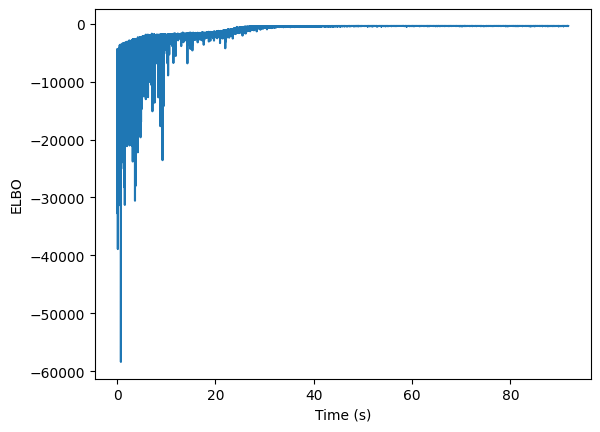

In [7]:
# ELBO
plt.plot(time_array[10:], -loss_array[10:])
plt.xlabel("Time (s)")
plt.ylabel("ELBO")
plt.show()

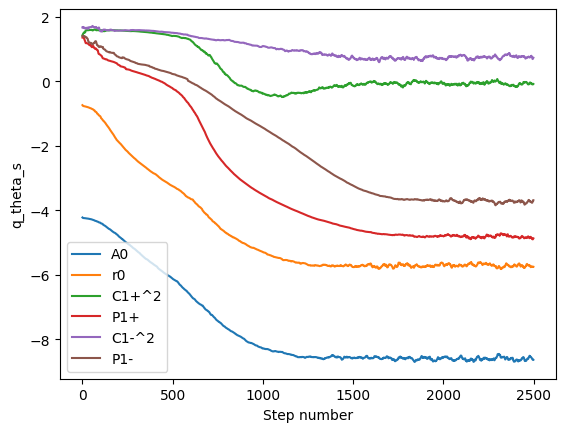

In [8]:
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.xlabel('Step number')
plt.ylabel('q_theta_s')
plt.legend(names)
plt.show()

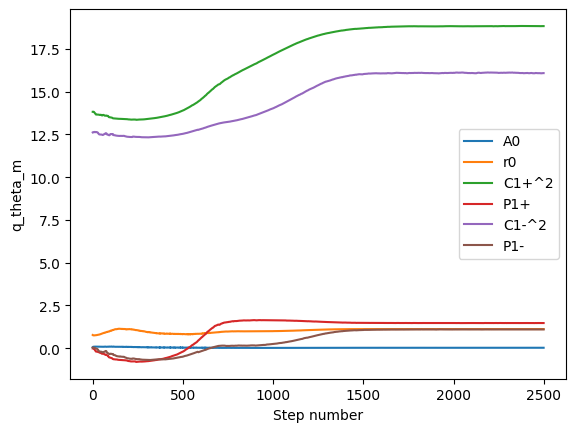

In [9]:
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.xlabel('Step number')
plt.ylabel('q_theta_m')
plt.legend(names)
plt.show()

/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisg

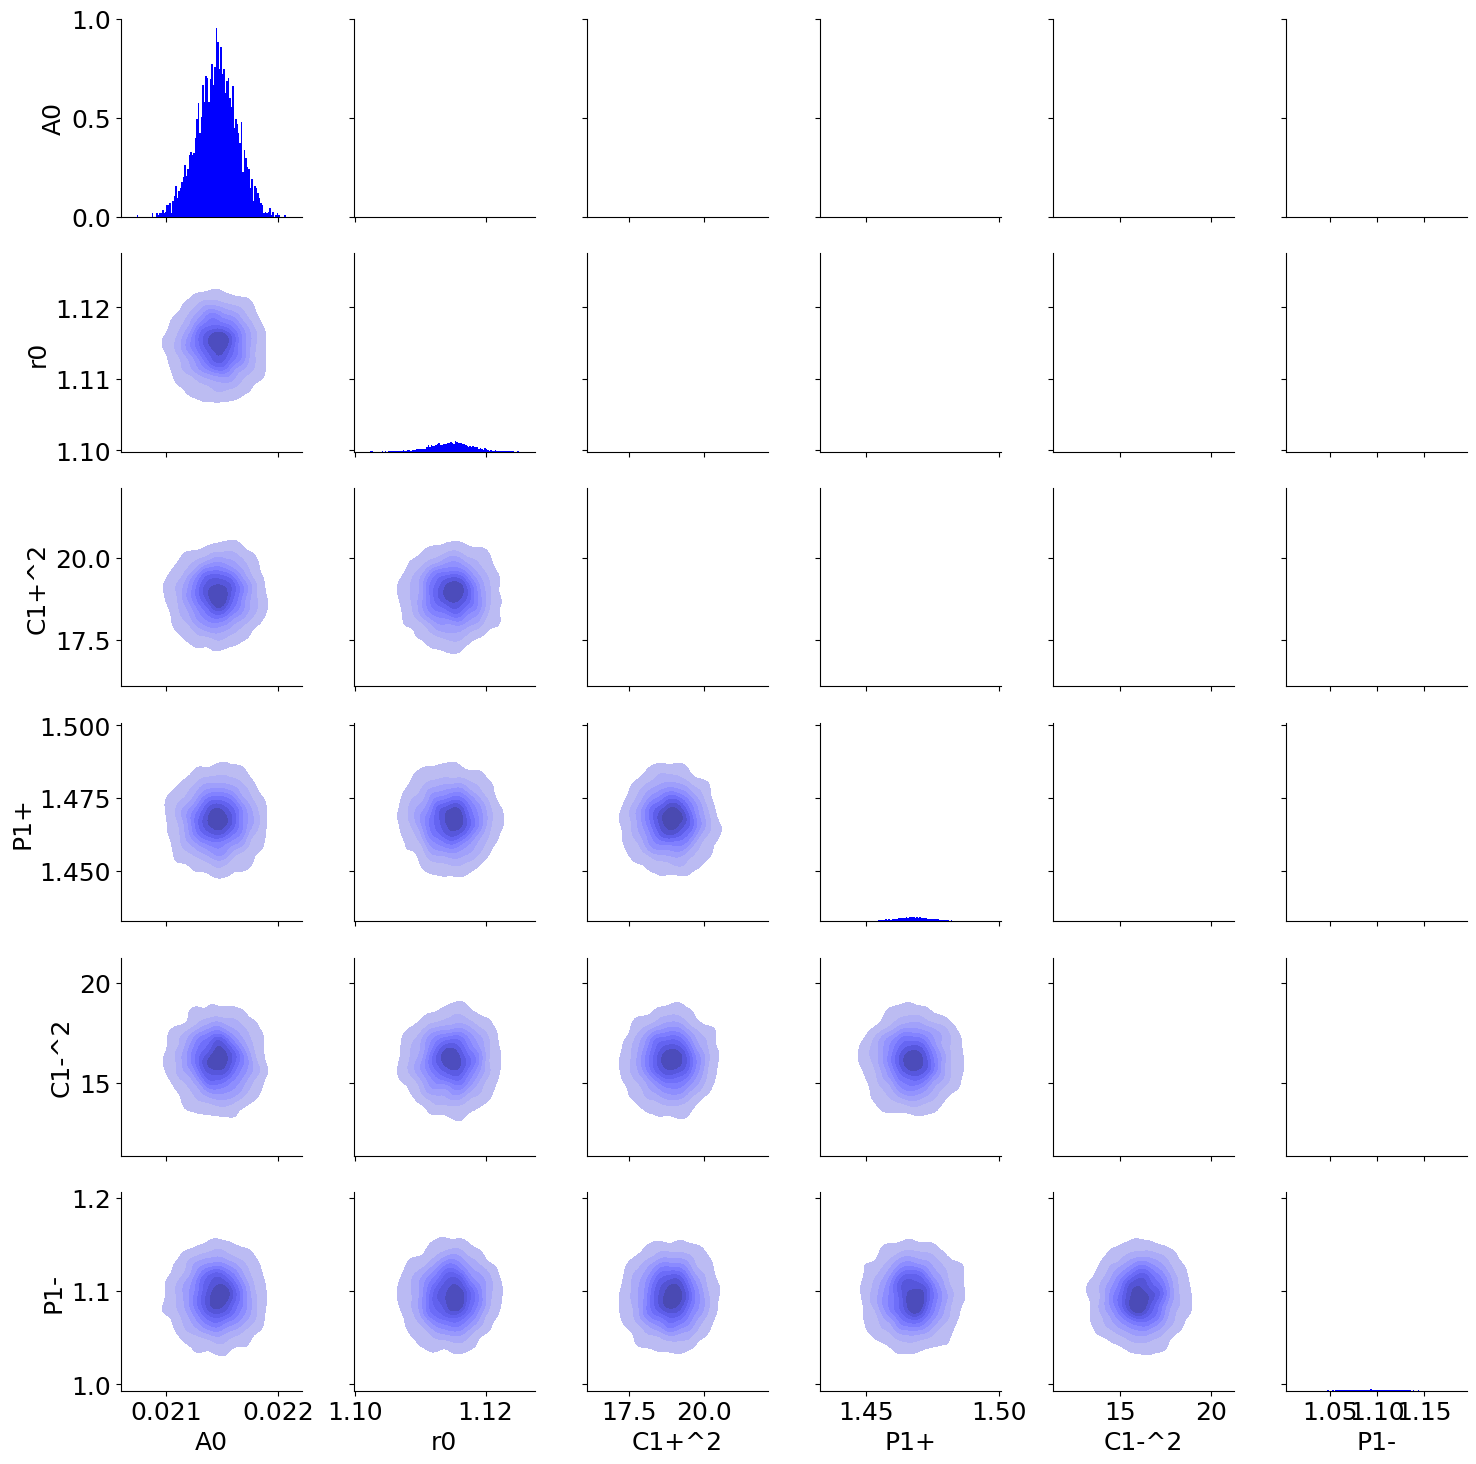

In [10]:
# VI Posteriors
model.nMC = 3000
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, model.q_theta_s)

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
g = sns.PairGrid(samples)
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh = 0.05, color = "blue")
plt.show()

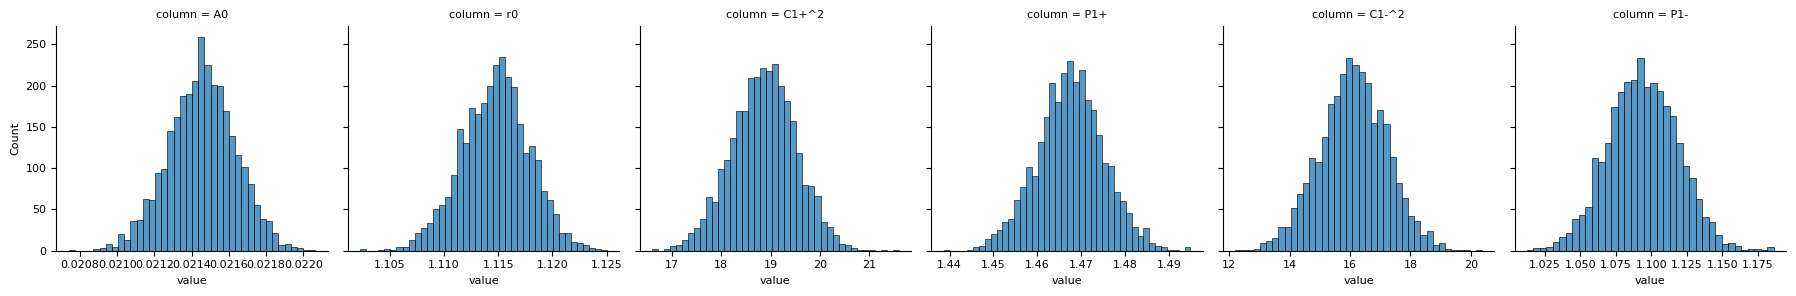

In [11]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 8})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(sns.histplot, 'value')
plt.show()

In [12]:
samples.median(axis = 0)

A0        0.021457
r0        1.114815
C1+^2    18.879612
P1+       1.467505
C1-^2    16.106480
P1-       1.093708
dtype: float64

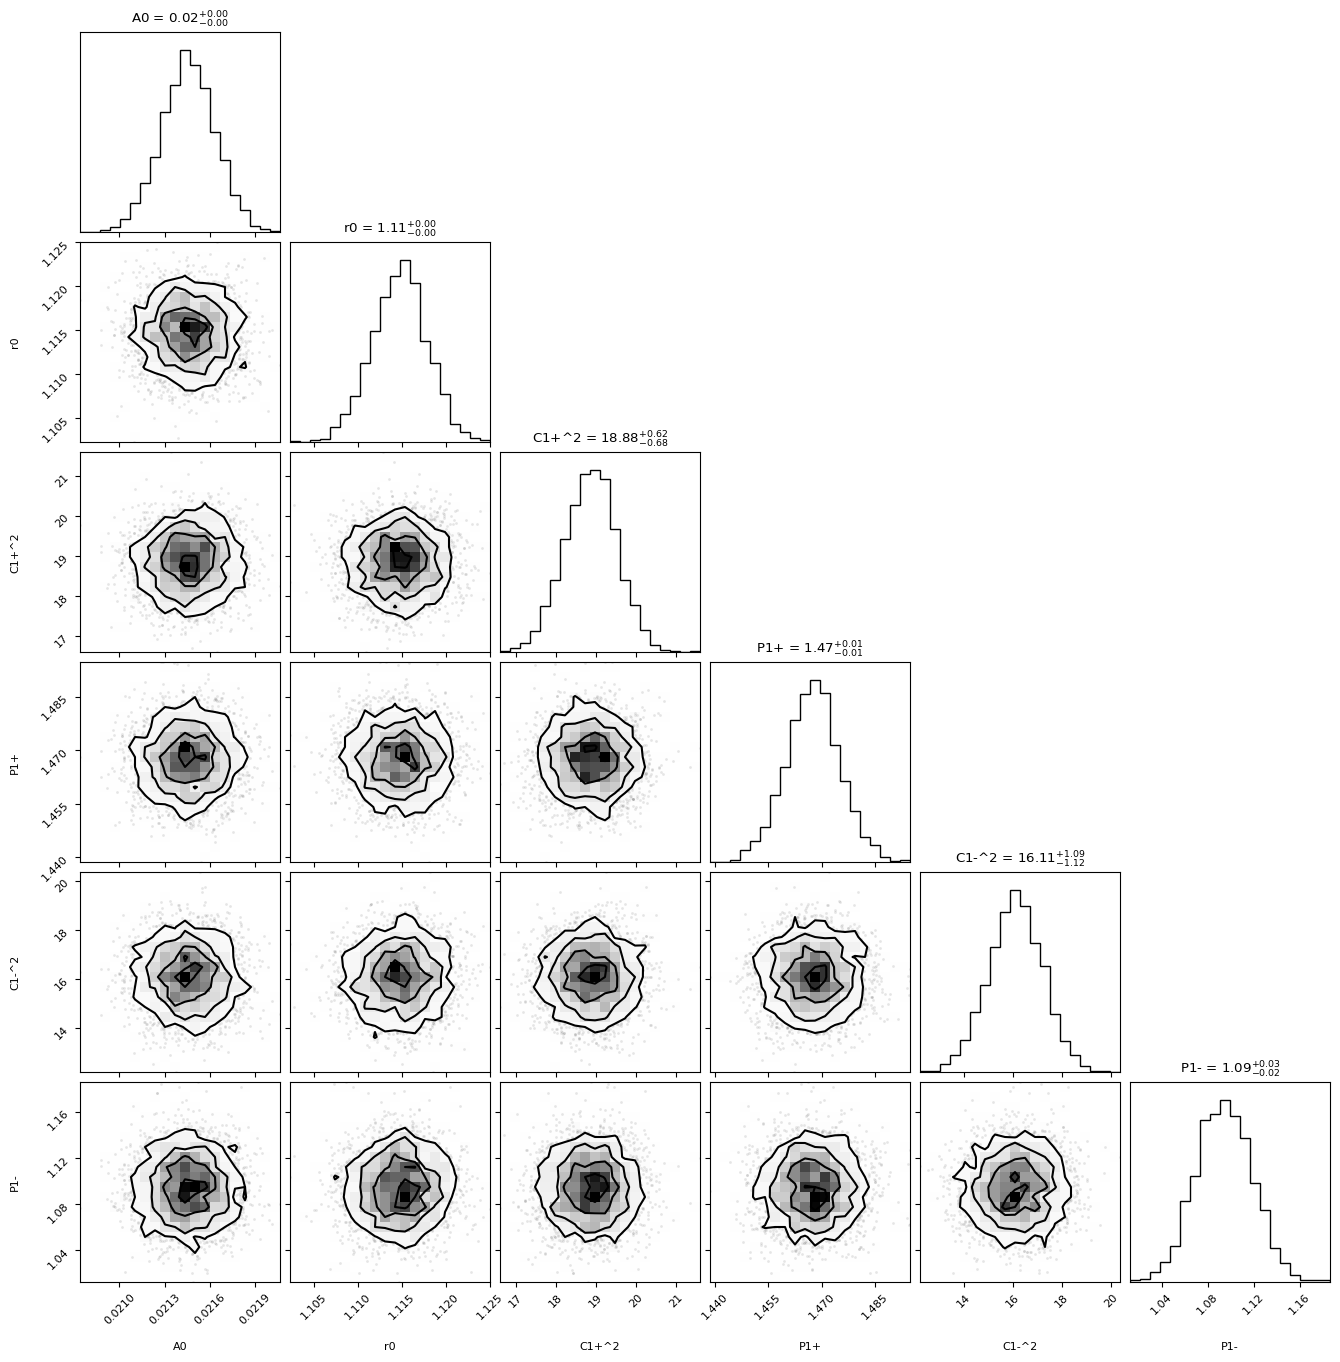

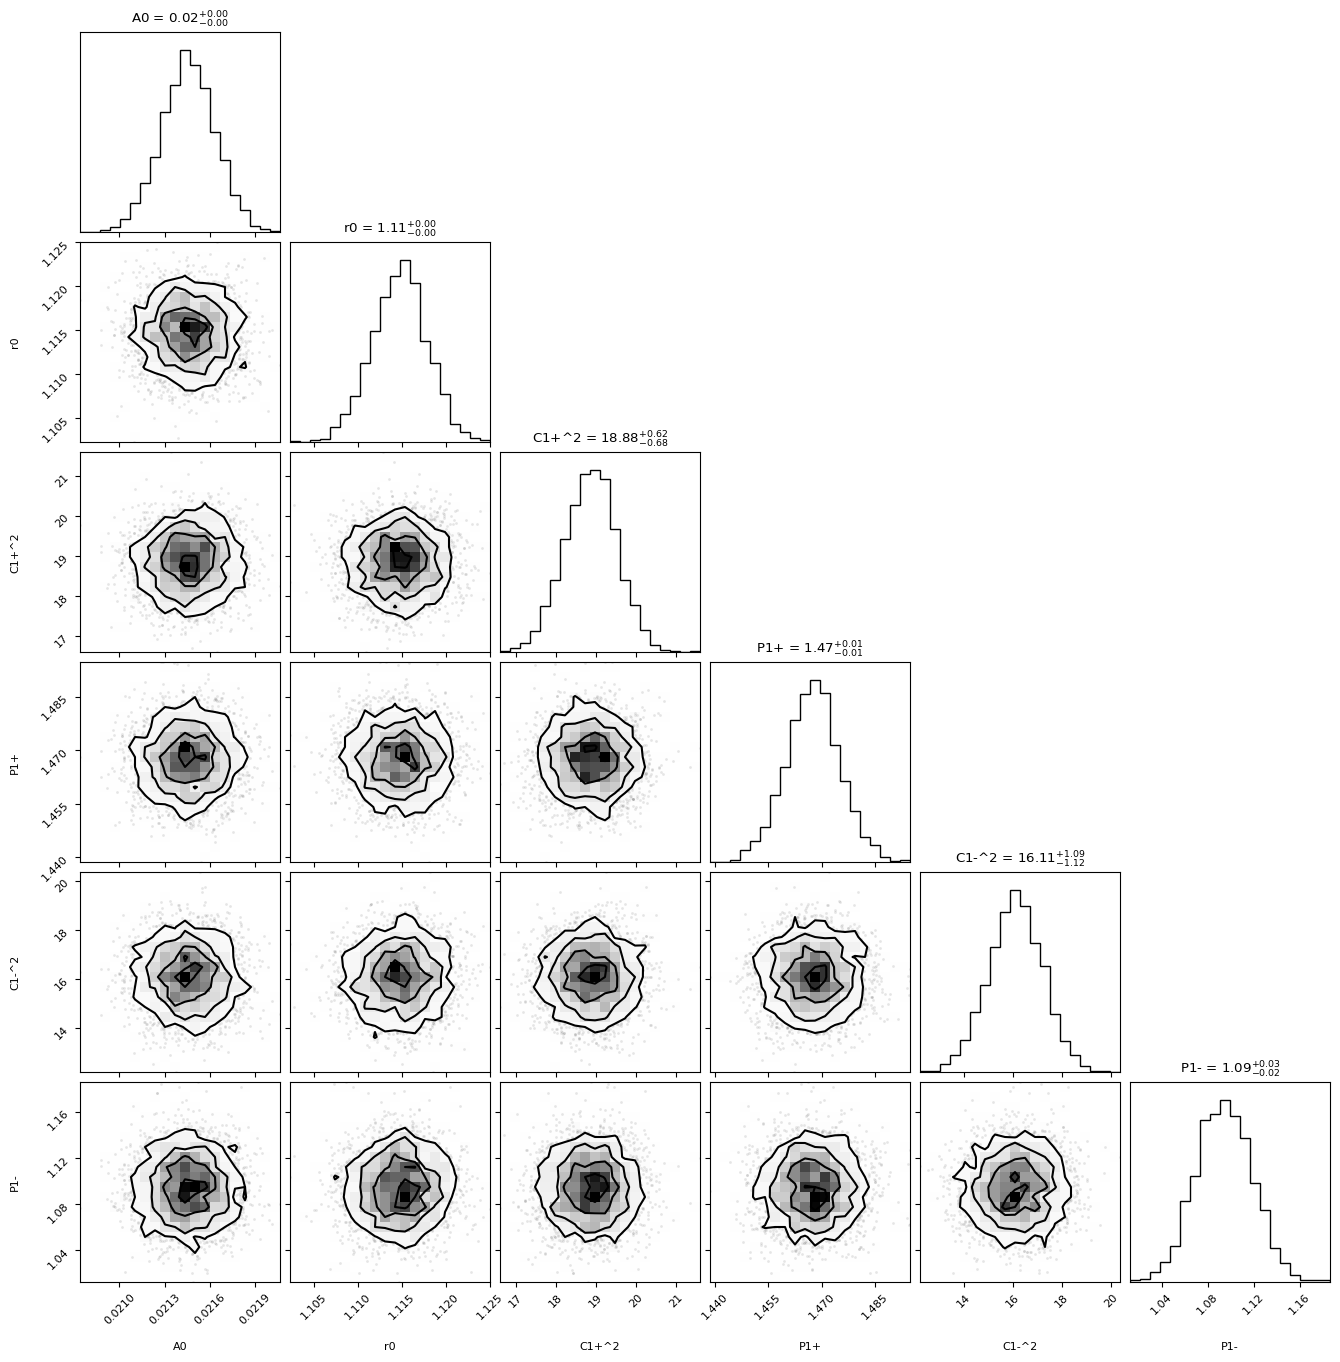

In [13]:
corner.corner(samples, labels = names, show_titles = True)

------------

### ELBO Optimization - Full Gaussian

In [14]:
######################################################################################################
######################################################################################################
######################################################################################################
# Andrius : I am not sure if there is something special you need to do to get the multimodal distribution
# but this is copied from your version of VBI_scattering.ipynb
######################################################################################################
######################################################################################################
######################################################################################################

torch.manual_seed(2)

### Data
x_train = torch.tensor(data_train.data[:, 1])
y_train = torch.tensor(data_train.data[:, 2])

### torch.nn.Module class instance
nMC = 5
param_dim = 6
f_dim = np.unique(data_train.data[:, 4]).shape[0]
x_dim = 1
model = MCElboFG(nMC, x_dim, param_dim, f_dim, err_cs = data_train.data[:, 3], 
                 Elab_cs = data_train.data[:, 0], f_sigmas = gauss_prior_f[:, 3], 
                 use_theory_cov = True, data_train = data_train)

learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 25000

# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []

start_time = time.time()
for t in range(0, n_steps):
    # Compute prediction
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradients
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Optimize
    optimizer.step()

    # Utility computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - start_time

    if t % 10 == 9:
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]

    if t % 100 == 99:
        print("Loss: {}, Step [{}/{}]".format(loss.item(), t, n_steps))
        # print(model.ModelString())
        # Time estimate
        print("Minutes remaining: {}".format((time.time() - start_time) * (n_steps - t) / (t * 60)))

endTime = time.time()
print(endTime - start_time)

/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/vbi_elbo2.py:561: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Hvalue_cs_real = torch.tensor(self.Hvalue_cs.real)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/vbi_elbo2.py:562: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Hvalue_cs_imag = torch.tensor(self.Hvalue_cs.imag)


Loss: 254753.21875, Step [99/25000]
Minutes remaining: 2.3729143828655332
Loss: 136411.03125, Step [199/25000]
Minutes remaining: 2.3130190875062993
Loss: 127734.9609375, Step [299/25000]
Minutes remaining: 2.328544275218428
Loss: 56569.7578125, Step [399/25000]
Minutes remaining: 2.320431325379868
Loss: 33364.80078125, Step [499/25000]
Minutes remaining: 2.3345099963979394
Loss: 26137.568359375, Step [599/25000]
Minutes remaining: 2.324539393296027
Loss: 9382.197265625, Step [699/25000]
Minutes remaining: 2.2886674951870325
Loss: 60482.94921875, Step [799/25000]
Minutes remaining: 2.2499124969200737
Loss: 9253.0625, Step [899/25000]
Minutes remaining: 2.2335514156828116
Loss: 8222.529296875, Step [999/25000]
Minutes remaining: 2.2615212262452427
Loss: 7212.8369140625, Step [1099/25000]
Minutes remaining: 2.2987904899547704
Loss: 12591.4248046875, Step [1199/25000]
Minutes remaining: 2.3094674736120515
Loss: 6528.904296875, Step [1299/25000]
Minutes remaining: 2.2978104265983634
Loss: 

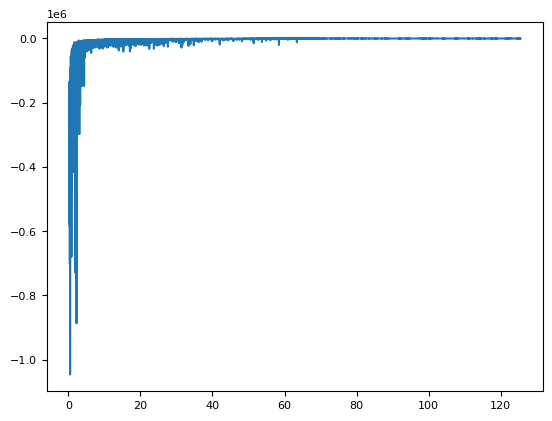

In [15]:
# ELBO
names = ["A0", "r0", "C1+^2", "P1+", "C1-^2", "P1-"]
plt.plot(time_array[50:], -loss_array[50:])
plt.show()

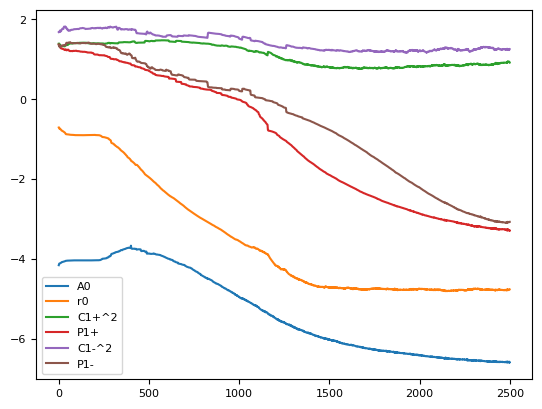

In [16]:
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

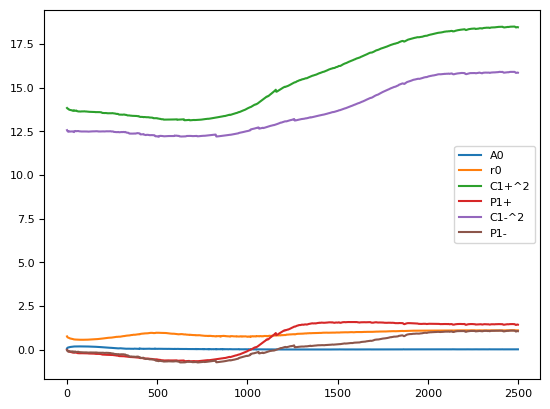

In [17]:
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

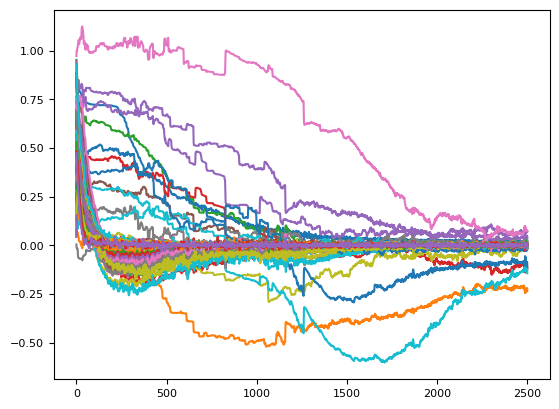

In [18]:
plt.plot(np.array(param_dictionary["q_theta_c"])[:,0,:])
plt.show()

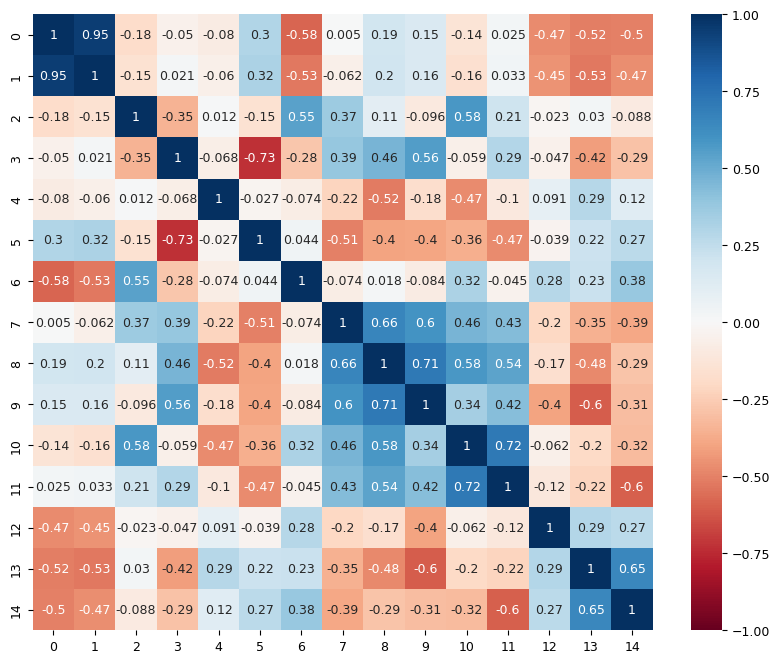

In [19]:
L = model.cholesky_factor()
S = L @ L.T
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 9})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3), vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

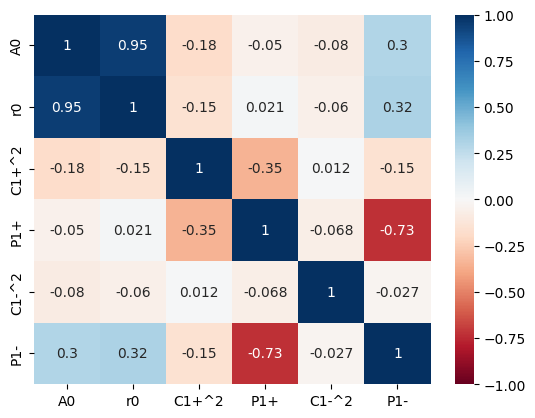

In [20]:
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(pd.DataFrame(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[:6,:6], columns = names, index = names), vmin=-1, vmax=1, annot=True, cmap=cmap)
plt.show()

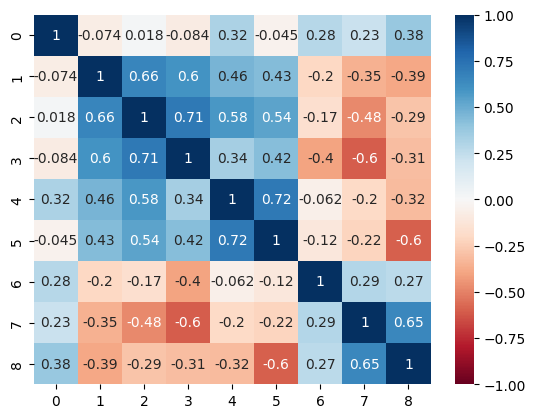

In [21]:
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[6:,6:], vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisg

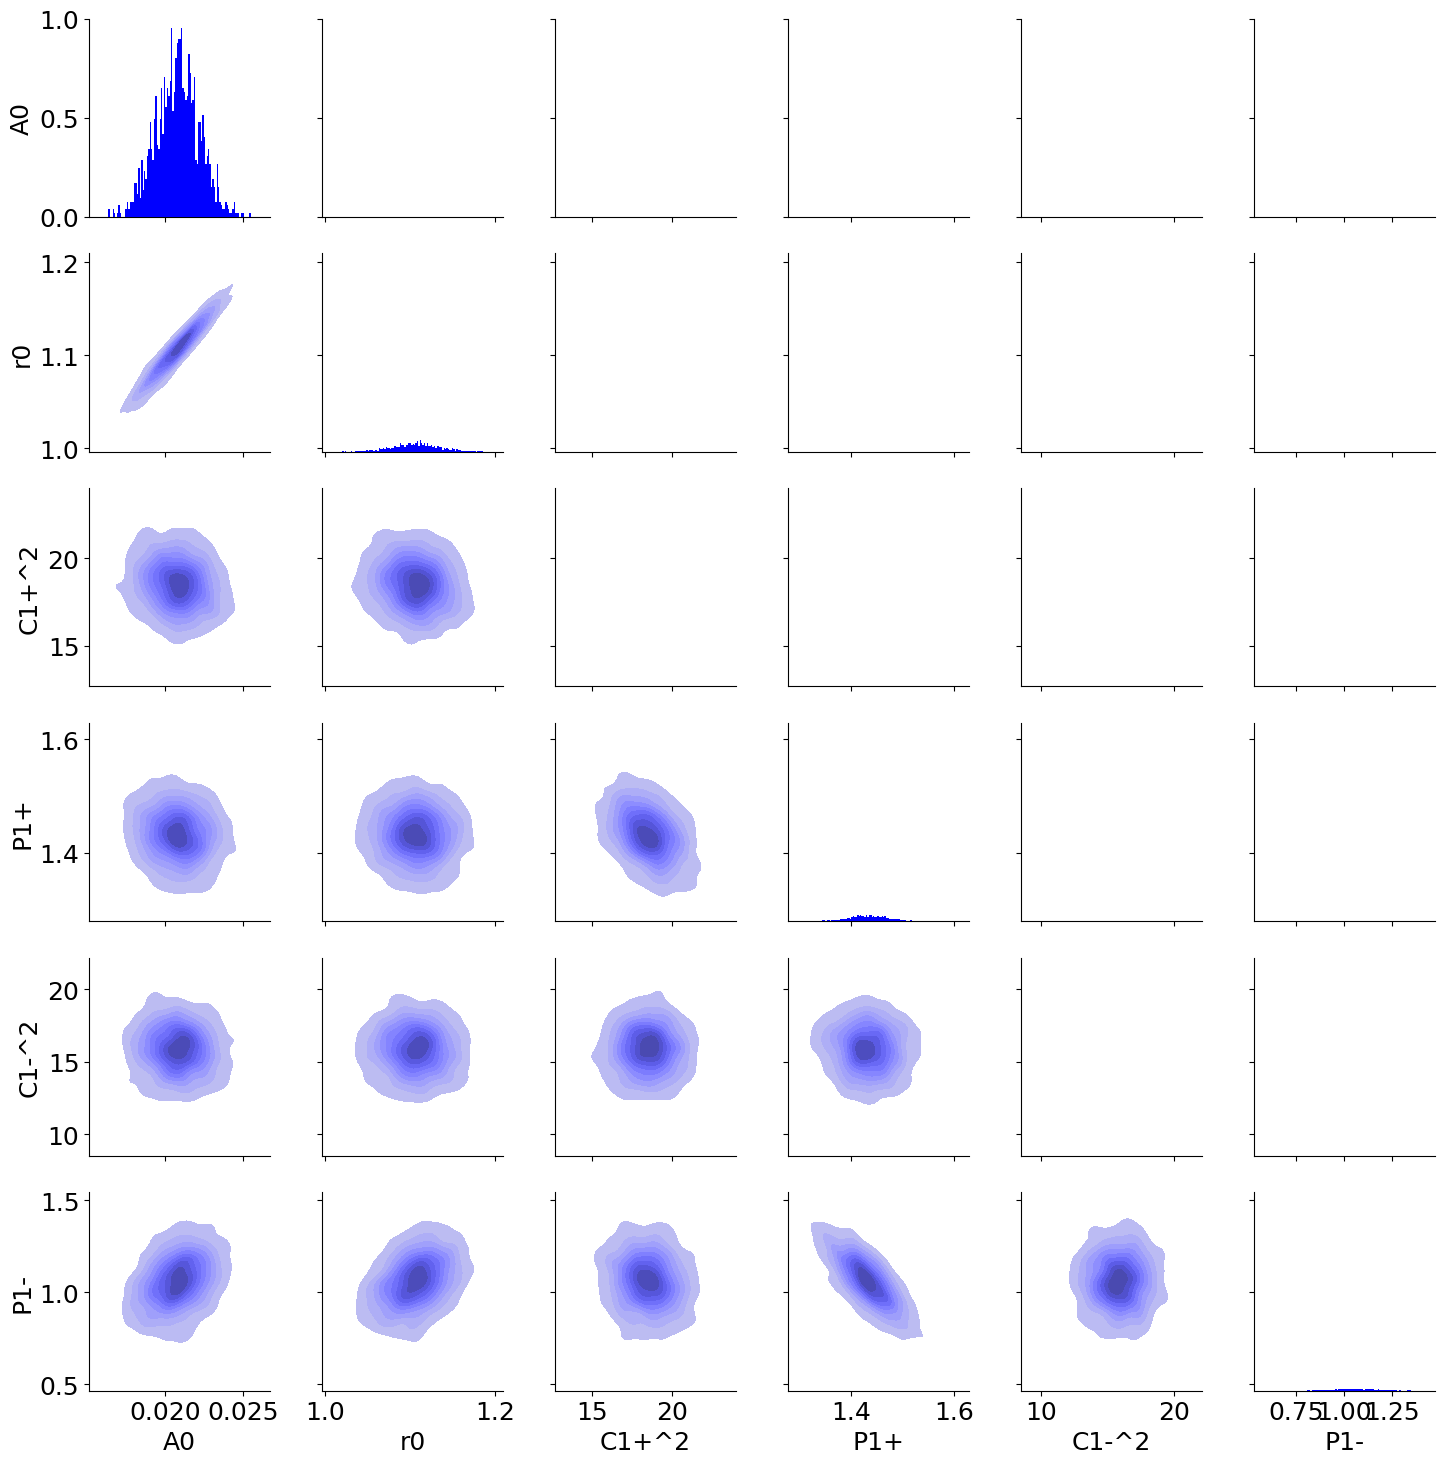

In [22]:
# VI Posteriors
model.nMC = 1500
L = model.cholesky_factor()
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, L) 

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
g = sns.PairGrid(samples)
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
plt.show()

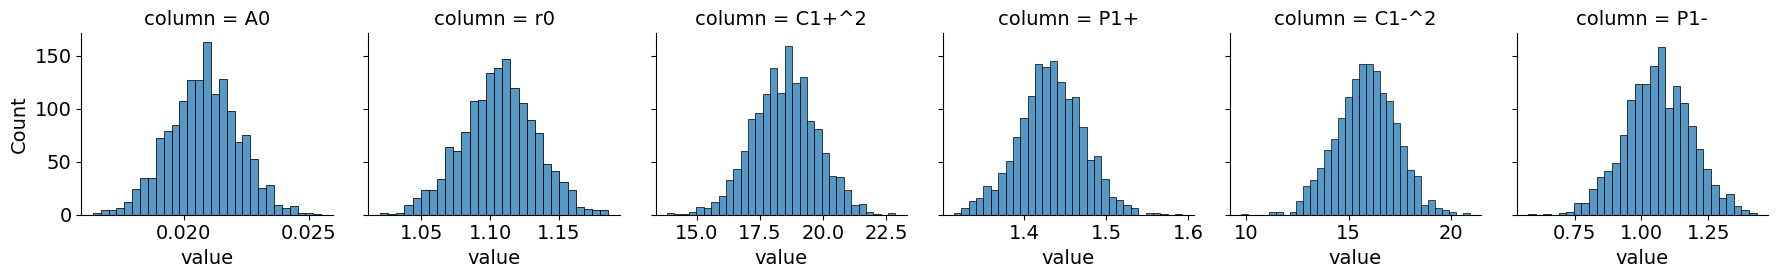

In [23]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(sns.histplot, 'value')
plt.show()